In [2]:
import gc
import itertools
import os
import pickle
import random
import sys
import warnings
from glob import glob
from pathlib import Path

import config
import japanize_matplotlib
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import scipy as sp
import torch
import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from lightgbm import LGBMClassifier, LGBMRegressor
from matplotlib_venn import venn2
from metric import macro_auc_score, score
from scipy.optimize import minimize
from seed import seed_everything
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
from xgboost import XGBClassifier, XGBRegressor

warnings.filterwarnings("ignore")


In [3]:
# ====================================================
# Configurations
# ====================================================
class CFG:
    DRY_RUN = True
    EXP_NAME = config.EXP_NAME
    AUTHOR = "marumarukun"
    COMPETITION = config.KAGGLE_COMPETITION_NAME
    DATA_PATH = config.COMP_DATASET_DIR
    OUTPUT_DIR = config.OUTPUT_DIR
    MODEL_PATH = config.OUTPUT_DIR / "models"  # モデル作成・実験時はこちらを使用(Notebookではこちらを使用)
    # MODEL_PATH = config.ARTIFACT_EXP_DIR(config.EXP_NAME) / "models"  # 提出時はこちらを使用(pyではこちらを使用)
    METHOD_LIST = ["lightgbm", "xgboost", "catboost"]
    METHOD_WEIGHT_DICT = {"lightgbm": 0.7, "xgboost": 0.2, "catboost": 0.1}
    SEED = 319
    n_folds = 2 if DRY_RUN else 5
    target_col_list = ["target"]
    # group_col = "category1"  # Required for GroupKFold (edit as needed)
    stratified_col = "target"  # Required for StratifiedKFold (edit as needed)
    num_boost_round = 100 if DRY_RUN else 1000000
    early_stopping_round = 10 if DRY_RUN else 100  # 10÷lrで設定
    verbose = 500

    # https://lightgbm.readthedocs.io/en/latest/Parameters.html
    # https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html
    # https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
    regression_lgb_params = {
        "objective": "regression",
        # "metric": "mae",
        "learning_rate": 0.1,
        "max_depth": 5,
        "min_child_weight": 1,
        "colsample_bytree": 0.8,
        "subsample": 0.8,
        "subsample_freq": 1,
        "seed": SEED,
        "device": "cpu",  # cpu/gpu/cuda
    }
    # https://xgboost.readthedocs.io/en/stable/parameter.html
    # https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
    # https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier
    regression_xgb_params = {
        "objective": "reg:squarederror",
        # "eval_metric": "mae",
        "learning_rate": 0.1,
        "max_depth": 5,
        "colsample_bytree": 0.8,
        "subsample": 0.8,
        "min_child_weight": 1,
        "enable_categorical": True,
        "random_state": SEED,
        "device": "cpu",  # cpu/gpu/cuda
    }
    # https://catboost.ai/docs/en/references/training-parameters/
    # https://catboost.ai/docs/en/concepts/python-reference_catboostregressor
    # https://catboost.ai/docs/en/concepts/python-reference_catboostclassifier
    regression_cat_params = {
        "loss_function": "RMSE",
        "learning_rate": 0.1,
        "iterations": num_boost_round,
        # "depth": 5,
        "grow_policy": "Lossguide",
        "random_seed": SEED,
        "task_type": "CPU",  # CPU/GPU
    }


In [4]:
# ====================================================
# Seed everything
# ====================================================
seed_everything(CFG.SEED)


In [5]:
# ====================================================
# Read data
# ====================================================
train_ss = pl.read_csv(CFG.DATA_PATH / "train_session.csv", try_parse_dates=True)
train_target = pl.read_csv(CFG.DATA_PATH / "train_target.csv", try_parse_dates=True)
test_ss = pl.read_csv(CFG.DATA_PATH / "test_session.csv", try_parse_dates=True)
train_log = pl.read_csv(CFG.DATA_PATH / "train_log.csv", try_parse_dates=True)
ec_log = pl.read_csv(CFG.DATA_PATH / "ec_log.csv", try_parse_dates=True, schema_overrides={"JAN": pl.String})
jan = pl.read_csv(CFG.DATA_PATH / "jan.csv", try_parse_dates=True)

train_test_ss = pl.concat([train_ss, test_ss])

# make index column
# train = train.with_row_index()
# test = test.with_row_index()


In [6]:
train_ss


session_id,売上日,時刻,店舗名,年代,性別,顧客CD
str,date,i64,str,str,str,str
"""3VrcoHzNbhVjwWry8bprTk""",2024-07-01,0,"""つくば""","""20代""","""不明""","""9545f047bcc38513f1bf9d420b615b…"
"""2BQUMmbDbCffCzmyCmJWXM""",2024-07-01,0,"""つくば""","""20代""","""不明""","""a8caaca05647788262c55ae79b3c6c…"
"""Bbi8hQdtC3CCJxULJYCE9F""",2024-07-01,0,"""つくば""","""20代""","""女性""","""33c89af908f24a3189312289978d1c…"
"""7zecHQC6svwsdprayEJCfR""",2024-07-01,0,"""つくば""","""20代""","""女性""","""395e3a5c2d0c006e619e8196e310e7…"
"""Dr2ky5Hdr8odb2uJQth8Hc""",2024-07-01,0,"""つくば""","""20代""","""女性""","""ed59f7160f6b18c34a510d2ea179e3…"
…,…,…,…,…,…,…
"""3z9pZTJPwY3b29rJV8Jqfc""",2024-10-31,23,"""門司店""","""60代""","""男性""","""34357aecb2373462e0a53d6ac425da…"
"""8sPiNmDQMay7K8bDpZNGvR""",2024-10-31,23,"""門司店""","""60代""","""男性""","""5cc57726b7fe4f0bff6e37a58267d2…"
"""TEo9tKEMw5kLHCf55sRzvC""",2024-10-31,23,"""門司店""","""60代""","""男性""","""c2820a47c280430c2a98507a1622ac…"


In [7]:
train_target


チョコレート,ビール,ヘアケア,米（5㎏以下）
i64,i64,i64,i64
0,0,0,0
0,0,0,0
0,0,0,0
0,0,0,0
0,0,0,0
…,…,…,…
0,0,0,0
0,0,0,0
0,0,0,0


In [8]:
test_ss


session_id,売上日,時刻,店舗名,年代,性別,顧客CD
str,date,i64,str,str,str,str
"""222qahkdkra4b7isEosZ5z""",2024-11-03,17,"""新宮店""","""40代""","""女性""","""c419920a6386b340b97b756bd8e8a5…"
"""223SvE3mDckZWaFKc4Ezmz""",2024-11-01,17,"""門司店""","""80代以上""","""女性""","""041b2b2aefd6357d65f46a7c2c81b1…"
"""224ZtFbG25byUwByo7s5Cz""",2024-11-07,11,"""新宮店""","""70代""","""男性""","""747f2ef45b420c75d3420158934956…"
"""227xpGcbQNAbpdP5LsYbGw""",2024-11-22,8,"""日田店""","""60代""","""女性""","""f6015f2951f94e6b23a39ee33e659b…"
"""2287s338C7P9qCcFbzLxSY""",2024-11-09,15,"""門司店""","""60代""","""男性""","""00b7ce1ab255befbe9f76690044a84…"
…,…,…,…,…,…,…
"""oZ8CYz7tmRnVAszZpzwVEg""",2024-11-02,17,"""新宮店""","""40代""","""不明""","""37d606447a37f18391e8bf3b743ff0…"
"""oZ8zCvKGd7RVMNVffZQfmg""",2024-11-05,12,"""日田店""","""70代""","""女性""","""4eb846f91c1354abc0293358ebdd8c…"
"""oZCeMk4vt4vQeebUutAVV7""",2024-11-02,11,"""日田店""","""50代""","""女性""","""f86d9fcb3206450612fe2d23efe0bd…"


In [9]:
jan.height


127070

In [10]:
train_log


session_id,JAN,売上数量,売上金額,値割数量,値割金額
str,i64,i64,i64,i64,i64
"""2222WjCzgbd2oEWF5AmrqQ""",4522646193879,1,219,0,0
"""2222WjCzgbd2oEWF5AmrqQ""",4522646735680,1,199,0,0
"""2222WjCzgbd2oEWF5AmrqQ""",4901340082946,1,79,0,0
"""2222WjCzgbd2oEWF5AmrqQ""",4901516013682,2,238,0,0
"""2222WjCzgbd2oEWF5AmrqQ""",4901626025902,1,99,0,0
…,…,…,…,…,…
"""oZEpwztdP4tzJc8i2BKYnw""",4522646835892,1,79,0,0
"""oZEpwztdP4tzJc8i2BKYnw""",4901577020650,1,179,0,0
"""oZEpwztdP4tzJc8i2BKYnw""",4901577085307,1,269,0,0


In [11]:
pl.Config.set_fmt_str_lengths(1000)
ec_log.head()


USER_ID,PURCHASED_AT,EC_SITE_NAME,UNIT_PRICE,AMOUNT,AMOUNT_WB,TOTAL_PRICE,TOTAL_PRICE_WB,ITEM_NAME,ITEM_URL,JAN,GENRE,GENDER_NAME,AGE_CATEGORY,FURUSATO_FLG,RAKUTEN_USER,WEIGHT_BACK_VALUE
str,"datetime[μs, UTC]",str,f64,f64,f64,f64,f64,str,str,str,str,str,str,i64,i64,f64
"""74aa584eddc336921bdac47fc6fe1ce970cfaeef3f2883072a3939b108d94bed""",2024-06-30 15:00:04 UTC,"""Rakuten""",2699.0,1.0,0.465978,2699.0,1257.673359,"""『店内全品ポイント2倍アップ！30日限定！09:00〜23:59 』＼クーポン利用で1,699円／【新感覚】デニム パンツ デニムパンツ レディース ワイドパンツ 春服 ワイド ズボン ジーンズ 春夏 ジーパン 夏服 体型カバー ボトムス ストレート ゆったり ゴム ウエスト""","""https://item.rakuten.co.jp/5000cshop/5zkdk-1/""",null,null,"""女性""","""30代""",0,1,0.465978
"""dd98b74fccc9331808a9e97cf56f02963fdd6cc2d9aad9c03736e10b81d67ef8""",2024-06-30 15:00:08 UTC,"""Rakuten""",15000.0,1.0,0.90608,15000.0,13591.198129,"""【7/1限定★最大50％OFF！ほぼ全品に使えるクーポン配布中】炭八 福袋 2024 大袋の数が選べる！炭八福袋 湿気 タンス 小袋 靴用ミニ 室内用 12L 押し入れやクローゼットの除湿に""","""https://item.rakuten.co.jp/granire-plus/sumi-41/""",null,"""日用品雑貨・文房具・手芸""","""男性""","""40代""",0,1,0.90608
"""b078067564ee40e3813b95fad803cb9a2918bffc072b8ece7c8bb4b42686e6a1""",2024-06-30 15:00:09 UTC,"""Rakuten""",1000.0,1.0,0.465978,1000.0,465.977532,"""漁師が作る鮭とば100g北海道産鮭とば 1000円ポッキリ 鮭トバ さけとば おつまみ【送料無料】【メール便】""","""https://item.rakuten.co.jp/kitanomachi/saketoba_100g/""",null,"""食品""","""女性""","""30代""",0,1,0.465978
"""2812f2353d41a98f57e11c782bf6de57f1942447fa1f73d0fcd3e719497fcfd0""",2024-06-30 15:00:12 UTC,"""Amazon""",null,1.0,0.800676,19250.0,15413.021242,null,null,null,null,"""男性""","""30代""",0,0,0.800676
"""bdda88ef299d4feec04c86b75d5188ea2dde37a807e26e973eba2942e7acfc97""",2024-06-30 15:00:12 UTC,"""Amazon""",null,1.0,0.564774,2759.0,1558.210743,null,null,null,null,"""男性""","""20代""",0,1,0.564774


顧客CD unique数: 227553
USER_ID unique数: 84290
両方に存在する数: 0


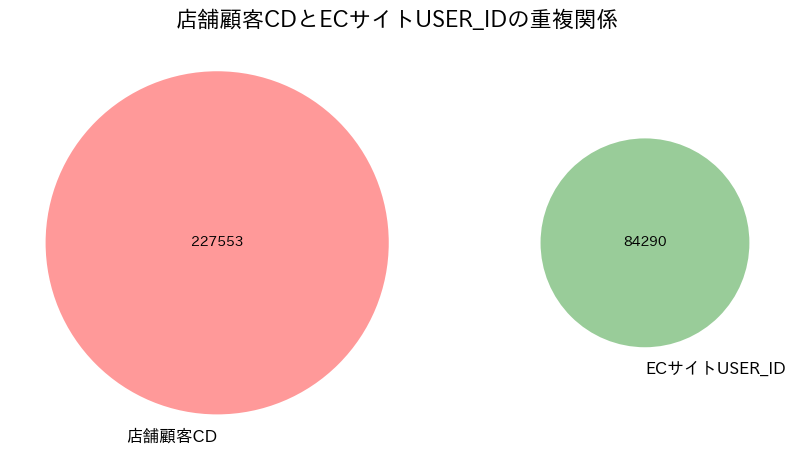

店舗顧客のうちECサイトも利用している割合: 0.00%
ECサイト利用者のうち店舗も利用している割合: 0.00%


In [12]:
# ====================================================
# 顧客CDとUSER_IDの関係をベン図で可視化
# ====================================================
# 顧客CDとUSER_IDの集合を作成
customer_cd_set = set(train_ss["顧客CD"].unique())
user_id_set = set(ec_log["USER_ID"].unique())

# 集合のサイズを確認
print(f"顧客CD unique数: {len(customer_cd_set)}")
print(f"USER_ID unique数: {len(user_id_set)}")
print(f"両方に存在する数: {len(customer_cd_set.intersection(user_id_set))}")

# ベン図の作成
plt.figure(figsize=(10, 6))
venn = venn2([customer_cd_set, user_id_set], ("店舗顧客CD", "ECサイトUSER_ID"))

plt.title("店舗顧客CDとECサイトUSER_IDの重複関係", fontsize=16)
plt.show()

# 重複している顧客の割合を計算
overlap_ratio_customer = len(customer_cd_set.intersection(user_id_set)) / len(customer_cd_set) * 100
overlap_ratio_user = len(customer_cd_set.intersection(user_id_set)) / len(user_id_set) * 100

print(f"店舗顧客のうちECサイトも利用している割合: {overlap_ratio_customer:.2f}%")
print(f"ECサイト利用者のうち店舗も利用している割合: {overlap_ratio_user:.2f}%")


顧客CD(train) unique数: 227553
顧客CD(test) unique数: 121415
両方に存在する数: 105548


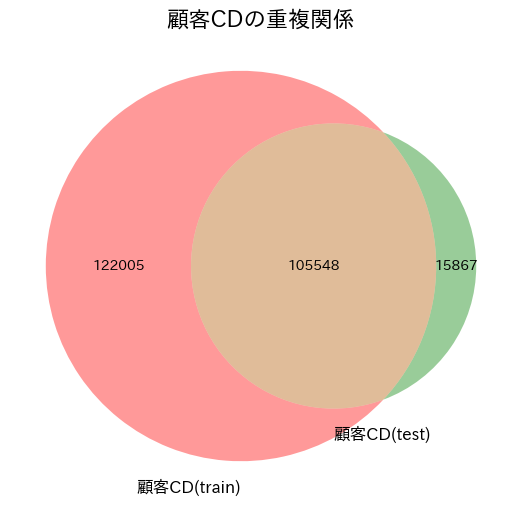

In [13]:
# ====================================================
# train, testの顧客CD関係をベン図で可視化
# ====================================================
# 顧客CDとUSER_IDの集合を作成
train_customer_cd_set = set(train_ss["顧客CD"].unique())
test_customer_cd_set = set(test_ss["顧客CD"].unique())

# 集合のサイズを確認
print(f"顧客CD(train) unique数: {len(train_customer_cd_set)}")
print(f"顧客CD(test) unique数: {len(test_customer_cd_set)}")
print(f"両方に存在する数: {len(train_customer_cd_set.intersection(test_customer_cd_set))}")

# ベン図の作成
plt.figure(figsize=(10, 6))
venn = venn2([train_customer_cd_set, test_customer_cd_set], ("顧客CD(train)", "顧客CD(test)"))

plt.title("顧客CDの重複関係", fontsize=16)
plt.show()

# 重複している顧客の割合を計算
overlap_ratio_customer = (
    len(train_customer_cd_set.intersection(test_customer_cd_set)) / len(train_customer_cd_set) * 100
)
overlap_ratio_user = len(train_customer_cd_set.intersection(test_customer_cd_set)) / len(test_customer_cd_set) * 100

# print(f"店舗顧客のうちECサイトも利用している割合: {overlap_ratio_customer:.2f}%")
# print(f"ECサイト利用者のうち店舗も利用している割合: {overlap_ratio_user:.2f}%")


In [17]:
# ====================================================
# 店舗名
# ====================================================
train_test_ss["店舗名"].unique()


店舗名
str
"""つくば"""
"""新宮店"""
"""福岡空"""
"""日田店"""
"""門司店"""
"""益浦店"""
